In [ ]:
import h2o, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
h2o.init()

In [ ]:
# Import the iris dataset into H2O:
iris = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv")
predictors = ["sepal_len", "sepal_wid", "petal_len", "petal_wid"]
iris_df = iris.as_data_frame()
iris_df.head()

## 1. Spectral-clustering sklearn

In [ ]:
from sklearn.cluster import SpectralClustering

for n_clus in [2,3,4]:
    tempdf = iris_df[predictors].copy()
    model = SpectralClustering(n_clusters=n_clus, affinity='nearest_neighbors', 
                               assign_labels='discretize').fit(tempdf)
    tempdf['label'] = [f"cluster_{cen+1}" for cen in model.labels_]
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    additional_info = tempdf['label'].value_counts().sort_index().to_dict()
    plt.suptitle(f"AgglomerativeClustering with n_clusters = {n_clus} {additional_info}")
    for idx, col in enumerate(predictors):
        sns.boxplot(tempdf, y=col, x='label', 
                    order=[f"cluster_{cen+1}" for cen in range(n_clus)],
                    ax=ax[idx])

Before looking at the comparison

In [ ]:
!pip install hdbscan

---------------
## 2. Comparison
In this example, we only focus on 2 most importance input in `iris` data (`petal_wid`, `petal_len`)

- Since `K-medians` is similar to `K-Means` (replacing `average value` by its `median-value` and only considered if the dataset has too many `outliers`) hence we didn't consider this algorithm in the comparison here.
- Also, here we focus on these following models


### 2.1. KMeans `(sklearn.cluster)`
-  Find the pair (`centroids-labels`) based on the distance of each data points to `centroid` 
- Must known the `n_clusters`

### 2.2. Mini-Batch KMeans `(sklearn.cluster)`
- `MiniBatchKMeans` is faster, but gives slightly different results (e.g. `total distance from centroids to data-point`)|

### 2.3. DBSCAN `(sklearn.cluster)`
Stand for **Density-Based Spatial Clustering of Applications with Noise**. It is a **density-based** algorithm that groups together points that are close to each other based on a density criterion. Points that are not part of any cluster are considered **noise**.
 - K-Means tends to work well when the data is well-separated and evenly distributed, while `DBSCAN` is better suited for datasets with irregular shapes or **varying densities**. 
 - `DBSCAN` is that it can find clusters of arbitrary shapes and sizes, unlike K-Means which assumes spherical clusters. `DBSCAN` is also **robust to noise and outliers** since they are not assigned to any cluster. 
 - However, `DBSCAN` can be **sensitive to the choice of distance metric** and parameters such as the `radius` and `minimum number of points` required to form a cluster. 
 
##### When to use
- Use `DBSCAN` when the data has irregular shapes or when there is no prior knowledge about the number of clusters. 
- Use K-Means when the data has spherical shapes and when the number of clusters is known beforehand. 
 
 If you are unsure which algorithm to use, it is always a good idea to try both algorithms and compare their results.
 
### 2.4. HDBSCAN `(hdbscan)`
The algorithm starts off much the same as `DBSCAN`: we transform the space according to density, exactly as `DBSCAN` does, and perform `single linkage clustering` on the transformed space.

Instead we have a new parameter `min_cluster_size` which is used to determine whether points are ‘falling out of a cluster’ or splitting to form two new clusters. This trades an unintuitive parameter for one that is not so hard to choose for `EDA` (what is the minimum size cluster should be choose)
- Choosing a minimum cluster size is very reasonable. The only remaining parameter is `min_samples` inherited from `DBSCAN` for the density based space transformation. **Sadly `min_samples` is not that intuitive; `HDBSCAN` is not that sensitive to it and we can choose some sensible defaults, but this remains the biggest weakness of the algorithm**.
- `HDBSCAN` is stable over runs and subsampling (since the variable density clustering will still cluster sparser subsampled clusters with the same parameter choices), and has good stability over parameter choices.
- When implemented well `HDBSCAN` can be very efficient. The current implementation has similar performance to fastcluster’s agglomerative clustering (and will use fastcluster if it is available), but we expect future implementations that take advantage of newer data structures such as cover trees to scale significantly better.

### 2.5. BIRCH `(sklearn.cluster)`
Stand for `Balanced Iterative Reducing and Clustering using Hierarchies`, it used to achieve hierarchical clustering over particularly huge data-sets
#### Pros
- Its capacity to incrementally and dynamically cluster incoming, multi-dimensional metric data points in an effort to generate the best quality clustering for a given set of resources (memory and time constraints). In most cases, Birch only requires a single scan of the database. 
- In addition, Birch is accepted as the, first clustering algorithm proposed in the database area to handle `'noise'` efficiently.
#### Cons
- Lacking interpretability with regard to cluster descriptors
- Inability to make correction after making spliting / merging decision
- For massive high dimensional

### 2.6. Agglomerative `(sklearn.cluster)`
Most common type of [hierarchical clustering algorithm](https://phamdinhkhanh.github.io/deepai-book/ch_ml/index_HierarchicalClustering.html). The fundamental idea is that you start with each point in it’s own `cluster` and then, for each `cluster`, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a `hierarchy`, or `binary tree`, of `clusters` branching down to the last layer which has a leaf for each point in the dataset. 

- At each iteration, similar `clusters` are merged until all of the data points are part of one big root `cluster`. 
- Best at finding small `clusters`.

#### Pros
- Stable across runs and the dendrogram shows how it varies over parameter choices (in a reasonably stable way), so stability is a strong point.
- Performance can be good if you get the right implementation.
#### Cons
- We have gotten rid of the globular assumption, but we are still assuming that all the data belongs in clusters with no `noise`.
- Similar to `K-Means` we are stuck choosing the number of clusters (not easy in EDA), or trying to discern some natural parameter value from a plot that may or may not have any obvious natural choices.

### 2.7. Mean-Shift `(sklearn.cluster)`
It is centroid based, like `K-Means` and affinity propagation, but can return clusters instead of a partition. 
- The underlying idea of the `Mean Shift algorithm` is that there exists some probability density function from which the data is drawn, and tries to place `centroids of clusters` at the **maxima of that density function**. 
- It approximates this via kernel density estimation techniques, and the key parameter `bandwidth` is then the `bandwidth of the kernel` used. 

This is easier to guess than the number of clusters, but may require some staring at, say, the distributions of pairwise distances between data points to choose successfully

- `Mean Shift` doesn’t cluster every point, but **it still aims for globular clusters, and in practice it can return less than ideal results**. Without visual validation it can be hard to know how wrong it may be.
- `Mean Shift` has more intuitive and meaningful parameters; this is certainly a strength.
- `Mean Shift` results can vary a lot as you vary the `bandwidth parameter` (which can make selection more difficult than it first appears. It also has a random initialisation, which means stability under runs can vary.
- While `Mean Shift` has good scalability in principle (using ball trees) in practice the `sklearn` implementation is **slow**; this is a serious weak point for `Mean Shift`.

### 2.8. OPTICS `(sklearn.cluster)`
Stand for `Ordering Points To Identify Clustering Structure`, it requires the same $\epsilon$ and `minPoints (or min_samples)` hyperparameters as `DBSCAN`, but with one important difference – the $\epsilon$ parameter is theoretically unnecessary. 

Beside that, `OPTICS` used $\xi$ to extract clusters by detecting valleys by steepness using the specified `\xi threshold`.

- Unlike `DBSCAN`, `OPTICS` generates a `hierarchical clustering` result for a variable neighborhood radius and is better suited for usage on large datasets containing clusters of varying density. 
- However, it is important to note that `OPTICS` has certain disadvantages compared to the `DBSCAN` algorithm. The two most significant disadvantages are memory cost and runtime complexity.

### 2.9. Affinity Propagation `(sklearn.cluster)`
`Affinity Propagation` is a newer clustering algorithm that uses a graph based approach to let points ‘vote’ on their preferred ‘exemplar’. The end result is a set of cluster ‘exemplars’ from which we derive clusters by essentially doing what `K-Means` does and assigning each point to the cluster of it’s nearest exemplar. `Affinity Propagation` has some **advantages** over `K-Means`. 
- First of all the graph based exemplar voting means that the user doesn’t need to specify the number of clusters. 
- Second, due to how the algorithm works under the hood with the graph representation it allows for non-metric dissimilarities (i.e. we can have dissimilarities that don’t obey the triangle inequality, or aren’t symmetric). This second point is important if you are ever working with data isn’t naturally embedded in a metric space of some kind; few clustering algorithms support, for example, non-symmetric dissimilarities. 
- Finally `Affinity Propagation` does, at least, have better stability over runs.

#### Disadvantages. 
- Since it partitions the data just like `K-Means` we expect to see the same sorts of problems, particularly with noisy data.
- `Affinity Propagation` it has ‘preference’ and ‘damping’ parameters but eliminate `n_clusters` which leads to difficult when choosing the number of clusters.
- This algorithm is slow; since it supports non-metric dissimilarities it can’t take any of the shortcuts available to other algorithms, and the basic operations are expensive as data size grows.

### 2.10. Spectral Clustering `(sklearn.cluster)`
`Spectral clustering` can **best be thought of as a graph clustering**. 
- For `spatial data` one can think of inducing a graph based on the distances between points (potentially a `k-NN graph`, or even a dense graph).  Since we don’t have a `sparse graph` (unless we prep one ourselves) so the result is a somewhat slower algorithm.
- From there spectral clustering will look at the eigenvectors of the Laplacian of the graph to attempt to find a good (low dimensional) embedding of the graph into Euclidean space. This is essentially a kind of manifold learning, finding a transformation of our original space so as to better represent manifold distances for some manifold that the data is assumed to lie on. 
- Once we have the transformed space a standard clustering algorithm is run; with sklearn the default is `K-Means`. That means that the key for spectral clustering is the transformation of the space. 
- Presuming we can better respect the manifold we’ll get a better clustering – we need worry less about `K-Means` globular clusters as they are merely globular on the transformed space and not the original space. 
- We unfortunately retain some of `K-Means` weaknesses: we still partition the data instead of clustering it; we have the hard to guess `‘number of clusters’ parameter`; we have stability issues inherited from `K-Means`. Worse, if we operate on the dense graph of the distance matrix we have a very expensive initial step and sacrifice performance.

### 2.11. Gaussian mixture model `(sklearn.mixture)`
The **advantage** is that `GMMs` can capture complex data distributions by modeling them as a mixture of Gaussian components. This allows for more flexibility in representing the data and can improve the adaptability of the model in different domains .

However, `GMMs` also have some limitations. 
- One disadvantage is that `GMMs` assume that the data is generated from a mixture of Gaussian distributions, which may not always be the case in real-world scenarios. This assumption can limit the model's ability to accurately represent the data and may lead to suboptimal performance in certain domains . 
- Additionally, `GMMs` can be computationally expensive to train and may require a large amount of labeled data for accurate estimation of the model parameters .

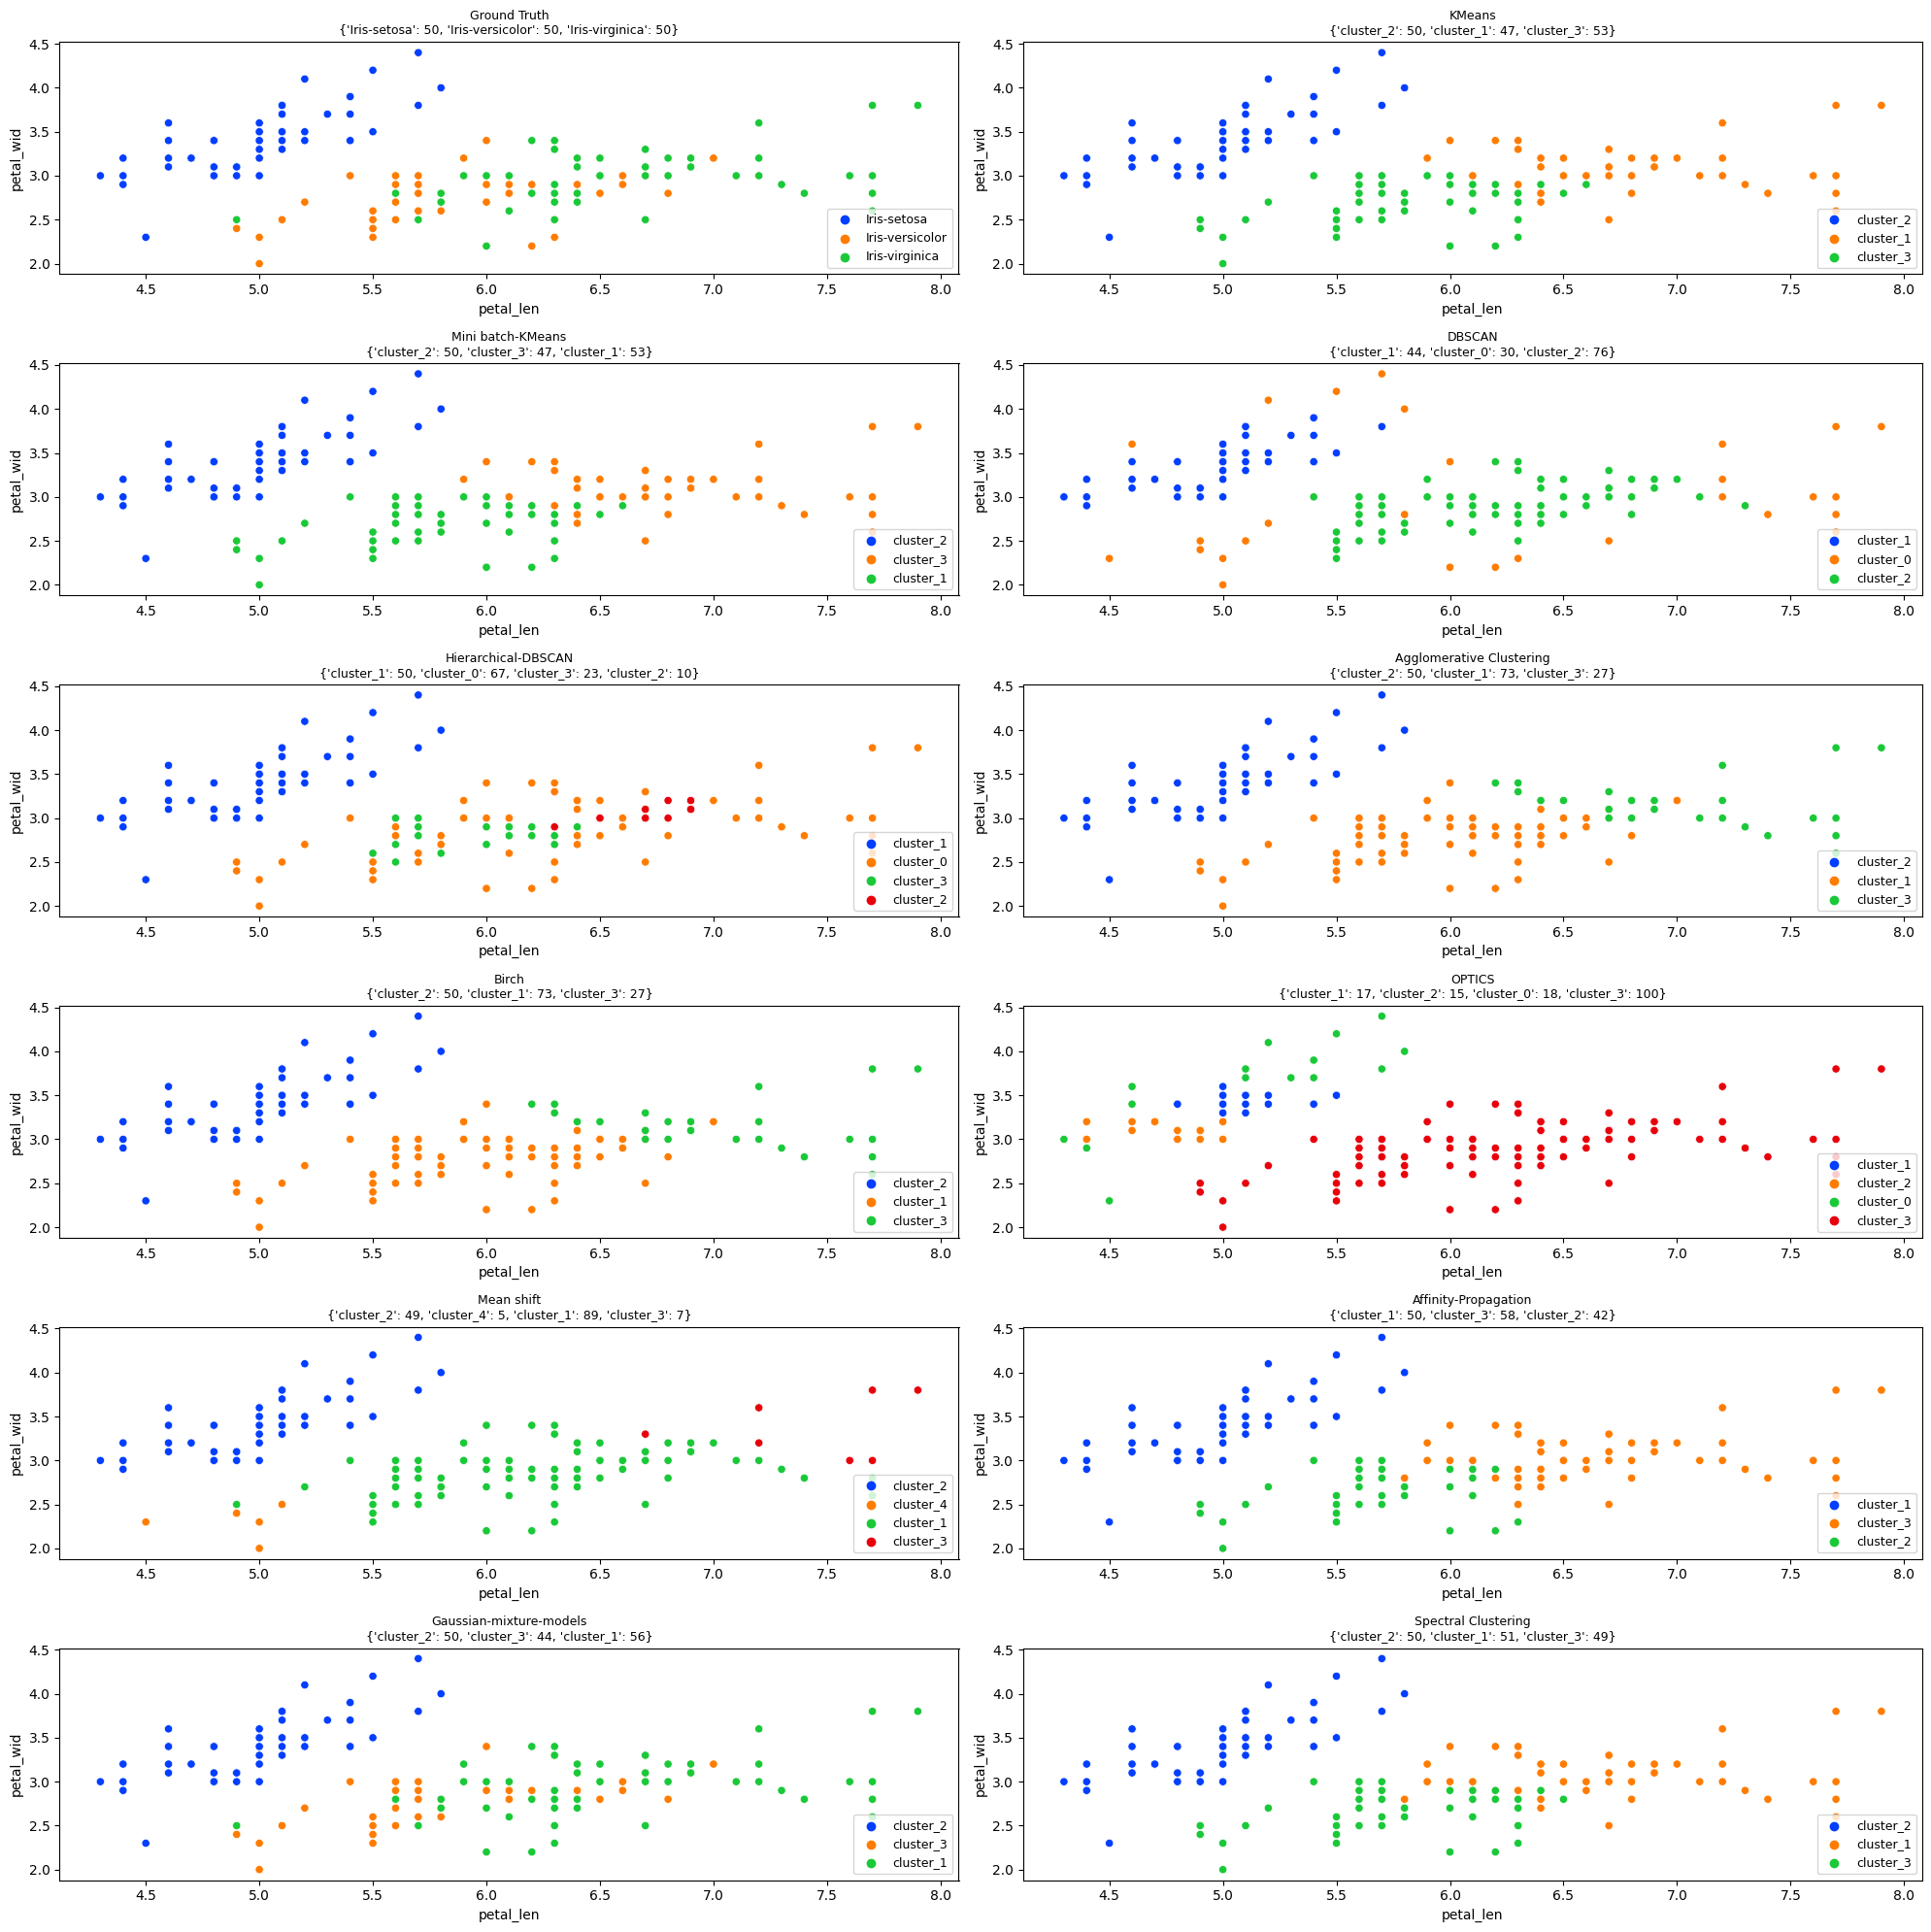

In [12]:
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans, Birch, AgglomerativeClustering, AffinityPropagation, MeanShift, OPTICS
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def fit_and_plot_clusters(X, y, n_clusters=3, seed=42):
    """
        Since the method to obtain the labels is difference (.fit vs .predict) 
        hence I didnt use loop on the algo-names
    """
    # Standard scaling
    X_scale = StandardScaler().fit_transform(X)
    # PCA to first 2 components
    X_scale = PCA(n_components=3).fit_transform(X_scale)
    
    # Initialize algorithms then fit to data
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(X_scale)
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_scale)
    hdbscan = HDBSCAN(min_cluster_size=8,  max_cluster_size=50, 
                      leaf_size=10, min_samples=5, cluster_selection_epsilon=0.05).fit(X_scale)
    mnbkmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10).fit(X_scale)
    agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X_scale)
    birch = Birch(threshold=0.03, n_clusters=n_clusters).fit(X_scale)
    affine = AffinityPropagation(preference=-50,damping=0.8, max_iter=500).fit(X_scale)
    mshift = MeanShift(bandwidth=1).fit(X_scale)
    optics = OPTICS(eps=0.25, min_samples=10, xi=0.1).fit(X_scale)
    spectral = SpectralClustering(  n_clusters=n_clusters, assign_labels='discretize',
                                    random_state=seed,
                                    affinity='rbf',
                                    ).fit(X_scale)
    gauss_mixmo = GaussianMixture(n_components=n_clusters).fit(X_scale)
    # for prediction labels
    y_preds = {}
    y_preds['Ground Truth'] = y
    y_preds['KMeans'] = [f"cluster_{k+1}" for k in kmeans.labels_]
    y_preds['Mini batch-KMeans'] = [f"cluster_{k+1}" for k in mnbkmeans.labels_]
    y_preds['DBSCAN'] = [f"cluster_{k+1}" for k in dbscan.labels_]
    y_preds['Hierarchical-DBSCAN'] = [f"cluster_{k+1}" for k in hdbscan.labels_]
    y_preds['Agglomerative Clustering'] = [f"cluster_{k+1}" for k in agglom.labels_]
    y_preds['Birch'] = [f"cluster_{k+1}" for k in birch.predict(X_scale)]
    y_preds['OPTICS'] = [f"cluster_{k+1}" for k in optics.labels_]
    y_preds['Mean shift'] = [f"cluster_{k+1}" for k in mshift.predict(X_scale)]
    y_preds['Affinity-Propagation'] = [f"cluster_{k+1}" for k in affine.predict(X_scale)]
    y_preds['Gaussian-mixture-models'] = [f"cluster_{k+1}" for k in gauss_mixmo.predict(X_scale)]
    y_preds['Spectral Clustering'] = [f"cluster_{k+1}" for k in spectral.labels_]
    
    # Plot predictions vs. ground truth
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 20))
    axes = axes.ravel()
    for i, name in enumerate(y_preds.keys()):
        ax = axes[i]
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_preds[name], ax=ax, legend=True, palette='bright')
        if type(y_preds[name]) == list:
            notes = Counter(y_preds[name])
        else:
            notes = Counter(y_preds[name].to_list())
        ax.set_title(f"{name}\n{dict(notes)}", fontsize=9)
        ax.legend(loc='lower right', fontsize=9)
        ax.set_ylabel("petal_wid")
        ax.set_xlabel("petal_len")
    plt.tight_layout()
    plt.show()

fit_and_plot_clusters(iris_df[predictors].to_numpy(), iris_df['class'])

### Notes on HDBSCAN
You must have a good EDA before implement this method

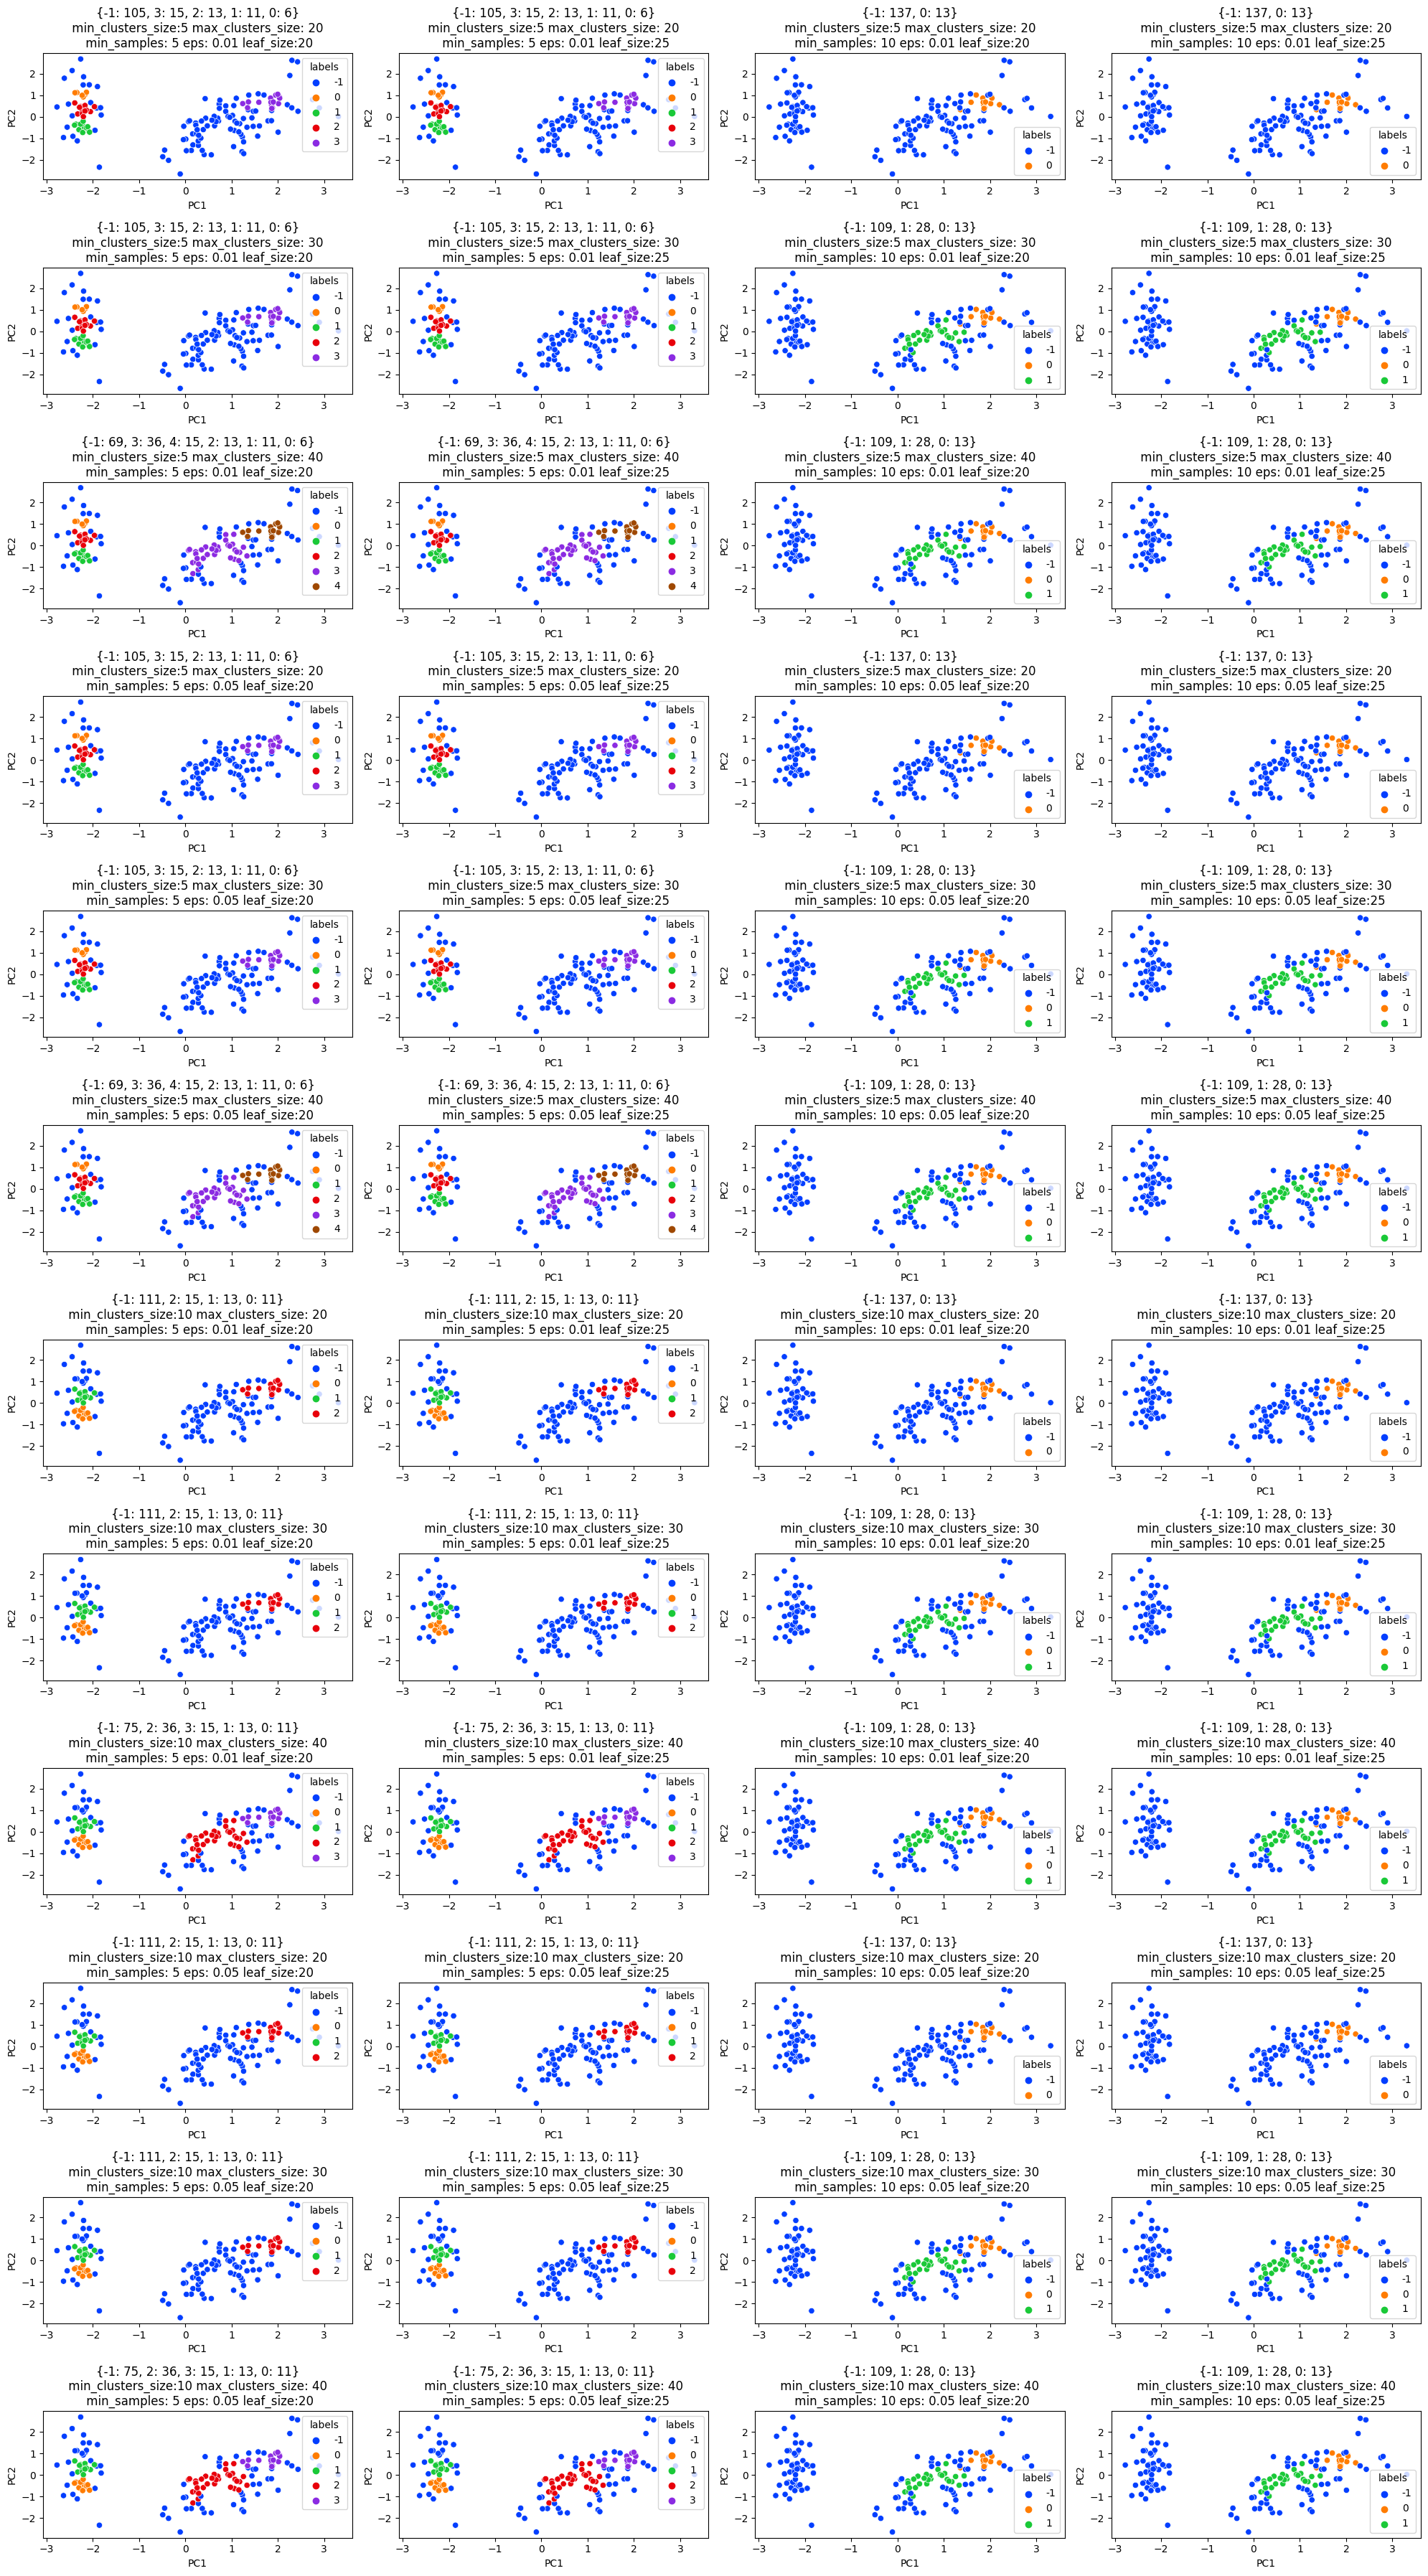

In [24]:
iris = sns.load_dataset("iris")
X = iris.drop(columns = "species").to_numpy()
X_scale = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_scale)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
#========================================================
fig, ax = plt.subplots(nrows=12, ncols=4, figsize=(20, 36))
ax = ax.ravel()
idx = 0
for mcs in [5,10]:
    for eps in [0.01, 0.05]:
        for mx in [20, 30, 40]:
            for m in [5,10]:
                for ls in [20, 25]:
                    model = HDBSCAN(min_cluster_size=mcs, max_cluster_size=mx, min_samples=m, 
                                    leaf_size = 20,
                                    cluster_selection_epsilon=eps).fit(X_pca)
                    pca_df['labels'] = model.labels_
                    sns.scatterplot(pca_df, x='PC1', y='PC2', hue='labels', ax=ax[idx], palette='bright')
                    ax[idx].set_title(f"{pca_df['labels'].value_counts().to_dict()}\n min_clusters_size:{mcs} max_clusters_size: {mx} \n min_samples: {m} eps: {eps} leaf_size:{ls}")
                    idx += 1
plt.tight_layout()

### Spectral clustering
This will be easier to control then using `HDBSCAN`

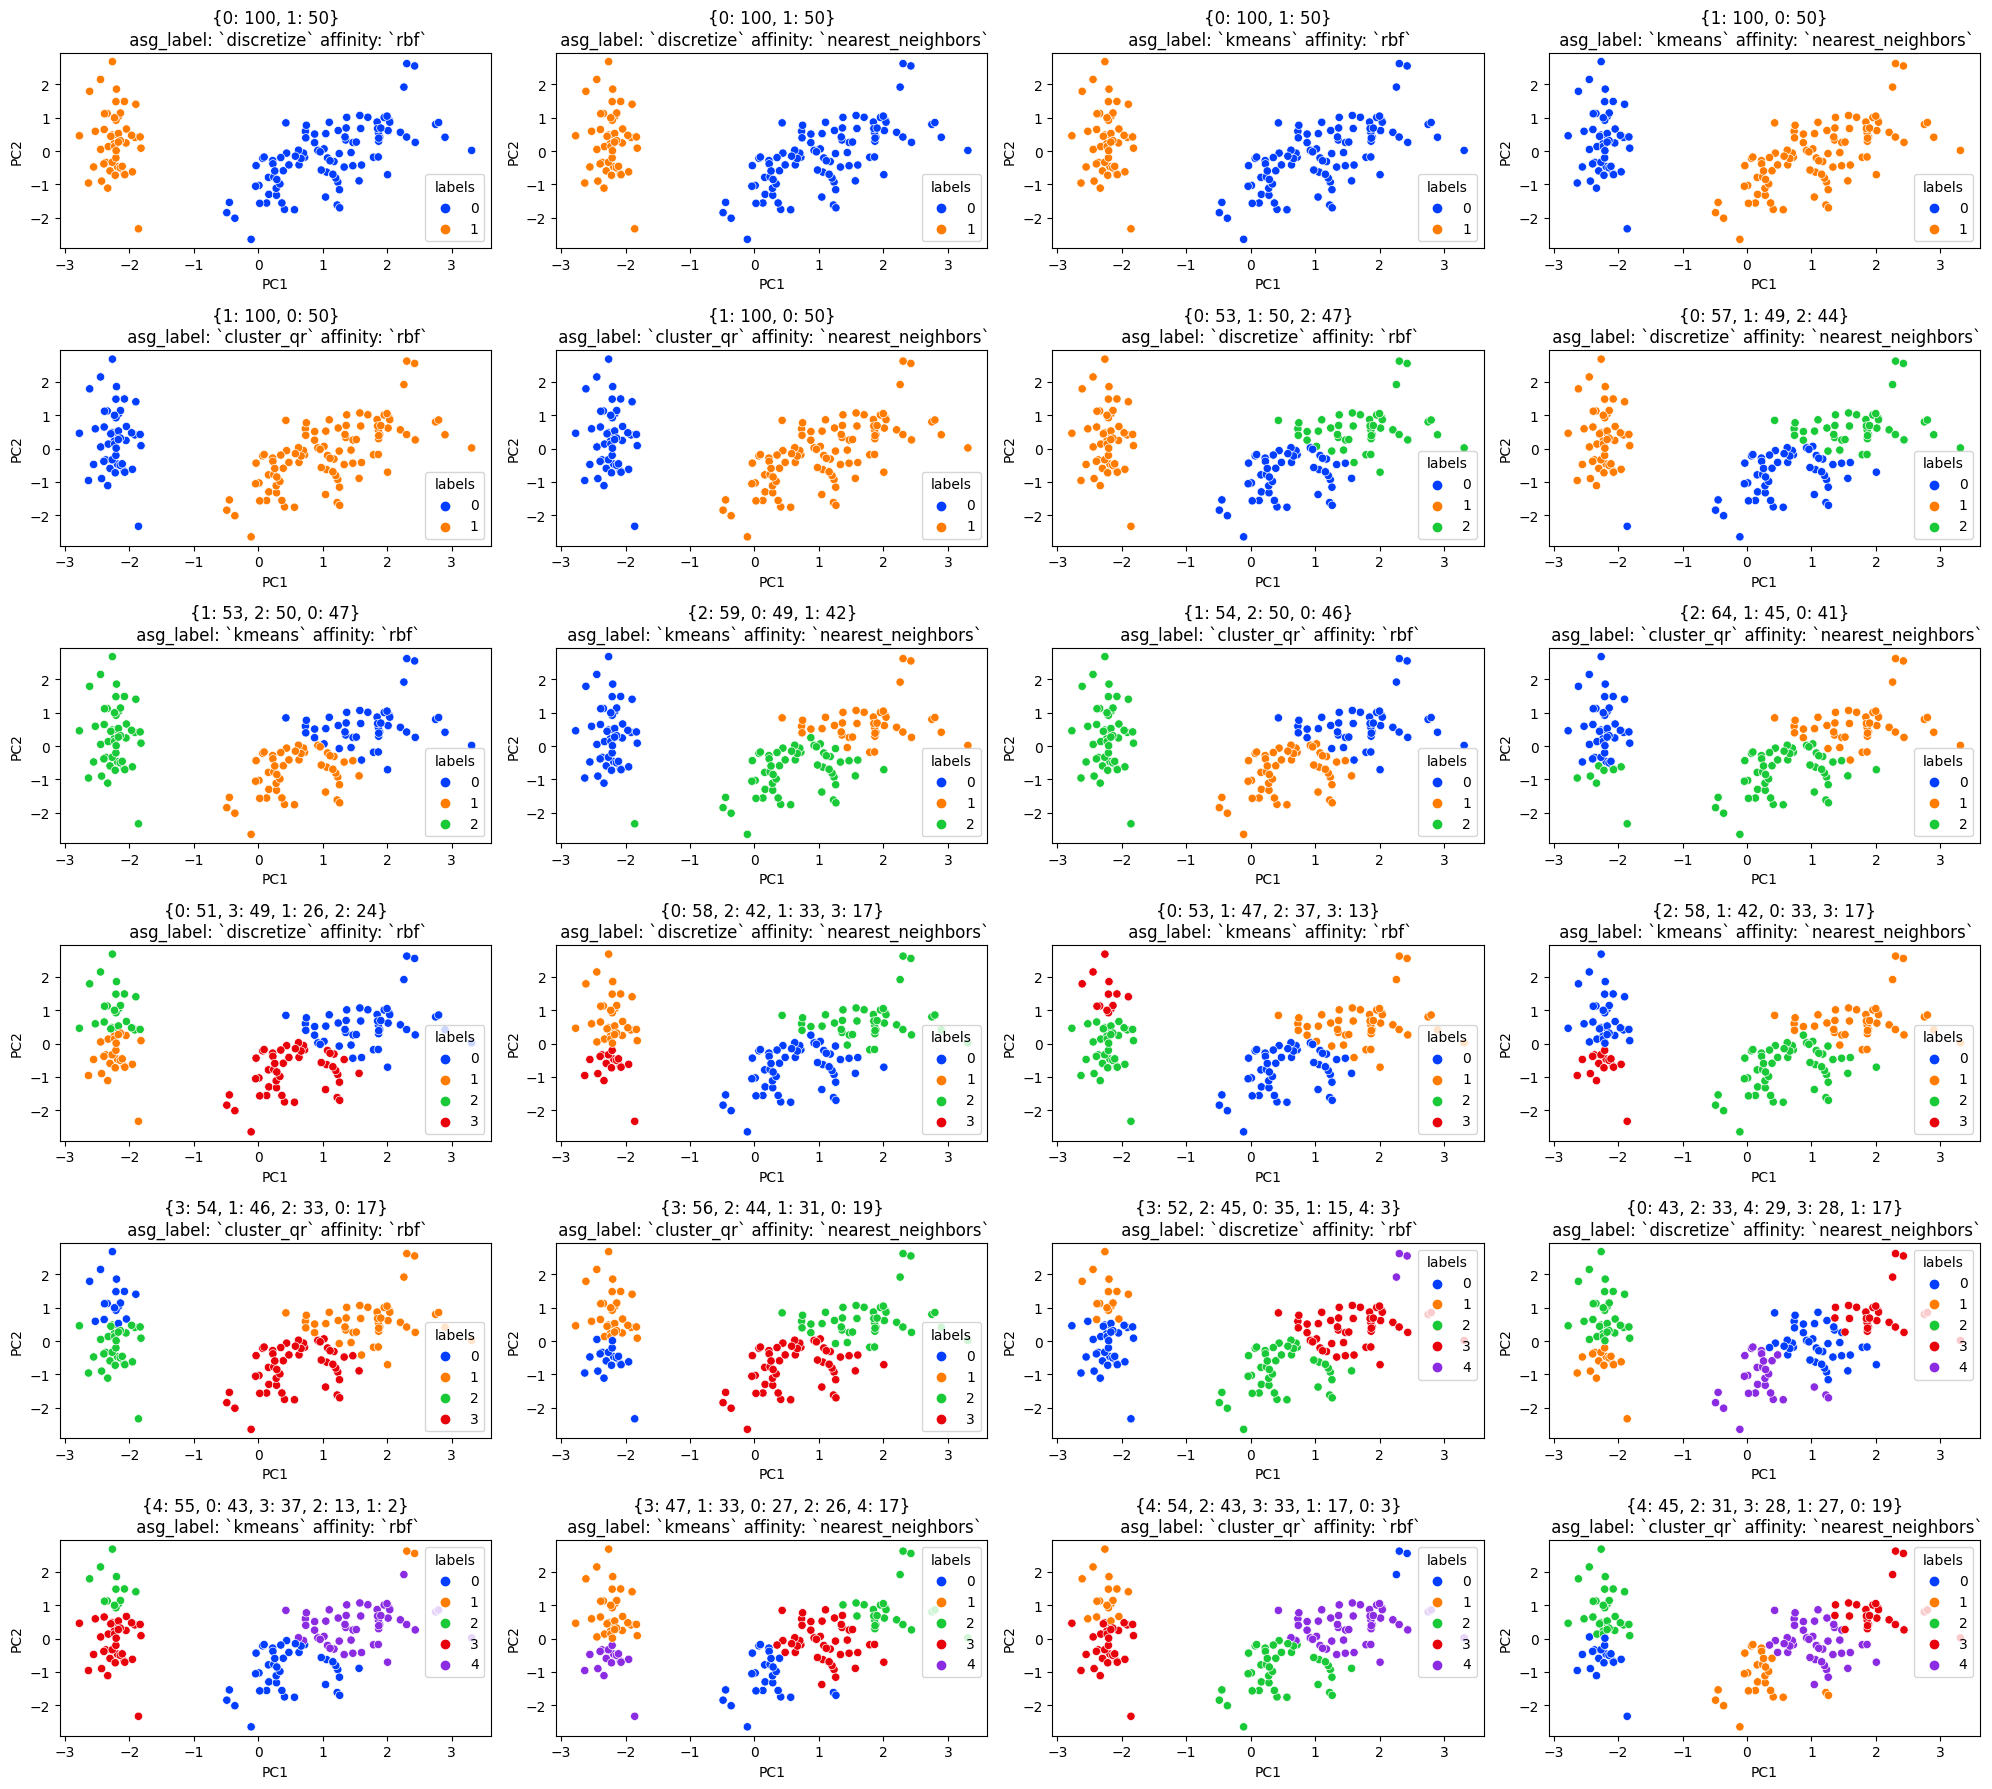

In [27]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 18))
ax = ax.ravel()
idx = 0
for n_clusters in [2,3,4,5]:
    for asg_lab in ["discretize", "kmeans", "cluster_qr"]:
        for afn in ['rbf', 'nearest_neighbors']:
            model = SpectralClustering(n_clusters=n_clusters, assign_labels=asg_lab,
                            affinity=afn,
                            ).fit(X_pca)
            pca_df['labels'] = model.labels_
            sns.scatterplot(pca_df, x='PC1', y='PC2', hue='labels', ax=ax[idx], palette='bright')
            ax[idx].set_title(f"{pca_df['labels'].value_counts().to_dict()}\n asg_label: `{asg_lab}` affinity: `{afn}`")
            idx += 1
plt.tight_layout()